In [1]:
#if necessary import the model data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import datetime
#Modeling Imports - GridSearch
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import TruncatedSVD 
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import GridSearchCV

#Models
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

#Unsupervised Models
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import fowlkes_mallows_score

#validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [2]:
#A summary of missing variables represented as a percentage of the total missing content. 
def null_summary(df, print_log=False, sort='ascending'):
    s = df.isnull().sum()*100/df.isnull().count()
    
    if sort.lower() == 'ascending':
        s = s.sort_values(ascending=True)
    elif sort.lower() == 'descending':
        s = s.sort_values(ascending=False)  
    if print_log: 
        print('Percentage of null values: \n', s)
  
    return pd.Series(s)

In [3]:
#get the data
talkdata = pd.read_csv('./data/talkdata.csv')
#Quick look at the head.
talkdata.head()

,timestamp,longitude,latitude,coordinates,is_active,phone_brand,device_model,category,gender,age,group
0,2016-05-01 14:23:37,0.0,0.0,"(0.0, 0.0)",1.0,小米,MI 2,1 free,M,35,M32-38
1,2016-05-01 14:23:37,0.0,0.0,"(0.0, 0.0)",1.0,小米,MI 2,Cozy 1,M,35,M32-38
2,2016-05-01 14:23:37,0.0,0.0,"(0.0, 0.0)",1.0,小米,MI 2,Industry tag,M,35,M32-38
3,2016-05-01 14:23:37,0.0,0.0,"(0.0, 0.0)",1.0,小米,MI 2,Property Industry 2.0,M,35,M32-38
4,2016-05-01 14:23:37,0.0,0.0,"(0.0, 0.0)",1.0,小米,MI 2,music,M,35,M32-38


In [4]:
#The size and shape of this dataset before categorical changing.
talkdata.shape

(7832282, 11)

In [5]:
#Set the timestamp column to a datetime datatype.
talkdata['timestamp'] = pd.to_datetime(talkdata.timestamp)
talkdata.timestamp.dtype

#create the categorical time columns
talkdata['hour'] = talkdata.timestamp.dt.hour
talkdata['weekday'] = talkdata.timestamp.dt.dayofweek
talkdata['week'] = talkdata.timestamp.dt.isocalendar().week

#concatenate the phone brand to the device model. 
talkdata['device_type'] = talkdata.phone_brand + " "+ talkdata.device_model
talkdata.describe(include='all', datetime_is_numeric=True)

,timestamp,longitude,latitude,coordinates,is_active,phone_brand,device_model,category,gender,age,group,hour,weekday,week,device_type
count,7832282,7.832282e+06,7.832282e+06,7832282,7.832282e+06,7832282,7832282,7832282,7832282,7.832282e+06,7832282,7.832282e+06,7.832282e+06,7.832282e+06,7832282
unique,NaN,NaN,NaN,32921,NaN,89,926,441,2,NaN,12,NaN,NaN,NaN,942
top,NaN,NaN,NaN,"(0.0, 0.0)",NaN,华为,荣耀6,Industry tag,M,NaN,M39+,NaN,NaN,NaN,华为 荣耀6
freq,NaN,NaN,NaN,2295988,NaN,2422726,354430,907153,5566437,NaN,1360719,NaN,NaN,NaN,354430
mean,2016-05-04 13:58:30.355242240,7.837463e+01,2.182485e+01,NaN,3.404700e-01,NaN,NaN,NaN,NaN,3.350478e+01,NaN,1.306016e+01,2.963128e+00,1.786502e+01,NaN
min,2016-04-30 23:52:24,-1.800000e+02,-3.380000e+01,NaN,0.000000e+00,NaN,NaN,NaN,NaN,1.100000e+01,NaN,0.000000e+00,0.000000e+00,1.700000e+01,NaN
25%,2016-05-02 20:22:46.500000,0.000000e+00,0.000000e+00,NaN,0.000000e+00,NaN,NaN,NaN,NaN,2.700000e+01,NaN,8.000000e+00,1.000000e+00,1.800000e+01,NaN
50%,2016-05-04 14:05:48,1.127500e+02,2.857000e+01,NaN,0.000000e+00,NaN,NaN,NaN,NaN,3.100000e+01,NaN,1.300000e+01,3.000000e+00,1.800000e+01,NaN
75%,2016-05-06 08:22:22,1.171700e+02,3.401000e+01,NaN,1.000000e+00,NaN,NaN,NaN,NaN,3.900000e+01,NaN,1.900000e+01,5.000000e+00,1.800000e+01,NaN
max,2016-05-08 00:00:08,1.511800e+02,5.364000e+01,NaN,1.000000e+00,NaN,NaN,NaN,NaN,8.900000e+01,NaN,2.300000e+01,6.000000e+00,1.800000e+01,NaN


In [6]:
null_summary(talkdata)

timestamp       0.0
longitude       0.0
latitude        0.0
coordinates     0.0
is_active       0.0
phone_brand     0.0
device_model    0.0
category        0.0
gender          0.0
age             0.0
group           0.0
hour            0.0
weekday         0.0
week            0.0
device_type     0.0
dtype: float64

In [7]:
y = talkdata.gender
#drop the non-categorical columnsand the columns that are no longer in use.
X = talkdata.drop(columns=['timestamp', 'longitude', 'latitude', 'phone_brand', 'device_model', 'gender', 'age', 'group'])
X.shape

(7832282, 7)

# Down Sample

I expect to have a lot more data unprocessed and waiting for me in production. In modeling; I want to reduce this dataset down to a workable amount, so that I can process and work with it. I will use 0.1% of the data for training/testing my model and will leave the rest as "what's in production". Which is what I would anticipate fitting the model on. 

The decision to use 0.1% was made after getting positive results from working with a dummy classifer on a sample of 0.05% of the data. In practice, I've experience lag and complications on datasets running over 750k. Discussions with colleagues were an agreement that 250k would be a fair amount. I think 1% of the data is decent. 

In [21]:
X_prod, X_train, y_prod, y_train = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
X_train.shape

(783229, 7)

In [22]:
X.columns

Index(['coordinates', 'is_active', 'category', 'hour', 'weekday', 'week',
       'device_type'],
      dtype='object')

In [23]:
y_train.value_counts()

M    556644
F    226585
Name: gender, dtype: int64

In [25]:
y_prod.value_counts()

M    5009793
F    2039260
Name: gender, dtype: int64

In [27]:
#Export the training data for later use.
X_train.to_csv('./data/train_features.csv', index=False)
y_train.to_csv('./data/train_target.csv', index=False)

#Export the prod data for later use. 
X_prod.to_csv('./data/prod_features.csv', index=False)
y_prod.to_csv('./data/prod_target.csv', index=False)

# Dimensionality Reduction:

The great search for the best dimension reduction parameters are done against a dummy classifier. This allows for reduced processing time as I seek to find the best parameters for machine learning models. The dummy classifer also helps determine whether or not I can get decent results from the data I've cleaned and processed.

These dummy models were run several time using different settings for the parameters; some higher - some lower. 

## TruncatedSVD (PCA)

In [12]:
#Truncated SVD
pipeline = Pipeline([('enc', OneHotEncoder(handle_unknown='ignore')), 
                     ('svd', TruncatedSVD()),
                     ('dc', DummyClassifier(strategy='most_frequent'))])
params = { 'svd__n_components' :  [50, 75, 60, 10],
          }
#run with verbosity then clear output for readability. 
search = GridSearchCV(pipeline, params, cv=5, verbose=1)
search.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  3.4min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('enc',
                                        OneHotEncoder(handle_unknown='ignore')),
                                       ('svd', TruncatedSVD()),
                                       ('dc',
                                        DummyClassifier(strategy='most_frequent'))]),
             param_grid={'svd__n_components': [50, 75, 60, 10]}, verbose=1)

In [34]:
print(f"best score: {search.best_score_} \n estimator: {search.best_estimator_}" )

best score: 0.7107039290992662 
 estimator: Pipeline(steps=[('enc', OneHotEncoder(handle_unknown='ignore')),
                ('svd', TruncatedSVD(n_components=50)),
                ('dc', DummyClassifier(strategy='most_frequent'))])


In [35]:
#an okay score, what's the classification report look like?
y_pred = search.predict(X_test)
print(classification_report(y_test, y_pred))

C:\Users\kalik\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           F       0.00      0.00      0.00     45317
           M       0.71      1.00      0.83    111329

    accuracy                           0.71    156646
   macro avg       0.36      0.50      0.42    156646
weighted avg       0.51      0.71      0.59    156646



As expected, I have an imbalanced dataset, so the data is not predicting the female population very well. Another model will be more effective at making these predictions. 

From the best score, I can tell that I can use this dataset to predict the gender. Additionally, the best parameters for truncateSVD against my classification models is determined as n_components=50.

## SelectKBest


In [ ]:
#First run for model selection on 250k records. It takes less than a minute to fit on five estimators. 
pipeline = Pipeline([('enc', OneHotEncoder(handle_unknown='ignore')), 
                     ('sk', SelectKBest()),
                     ('dc', DummyClassifier(strategy='most_frequent'))])
params = { 'sk__score_func' :  [chi2, f_classif],
           'sk__k' : [100, 90, 95, 110]
          }
#run with verbosity then clear output for readability. 
search = GridSearchCV(pipeline, params, cv=5, verbose=1)
search.fit(X_train, y_train)


In [45]:
print(f"best score: {search.best_score_} \n estimator: {search.best_estimator_}" )

best score: 0.7107039290992662 
 estimator: Pipeline(steps=[('enc', OneHotEncoder(handle_unknown='ignore')),
                ('sk',
                 SelectKBest(k=100,
                             score_func=<function chi2 at 0x00000167ACD188B8>)),
                ('dc', DummyClassifier(strategy='most_frequent'))])


In [51]:
#an okay score, what's the classification report look like?
y_pred = search.predict(X_test)
print(classification_report(y_test, y_pred))

C:\Users\kalik\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           F       0.00      0.00      0.00     45317
           M       0.71      1.00      0.83    111329

    accuracy                           0.71    156646
   macro avg       0.36      0.50      0.42    156646
weighted avg       0.51      0.71      0.59    156646



# GridSearch Parameters

## Late Modeling
Start Here after running imports and functions

In [3]:
# Emergency Call: For use after kernel shut down!
X_train = pd.read_csv('./data/train_features.csv')
y_train = pd.read_csv('./data/train_target.csv')
y_train = y_train.values.ravel()
y_train.shape

(783229,)

In [4]:
#The training dataset can now be used for training/testing against models.
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
X_train.shape

(626583, 7)

In [5]:
#Helper function. y_train and X_train are assumed to have been defined in the notebook.
def print_scores(model, y_train=y_train, X_train=X_train):
    print("Roc_AUC Score: ", roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]))
    print(f"best score: {model.best_score_} \n estimator: {model.best_estimator_}")

In [6]:
#Helper function. Prints the classification report.
def class_rep(model, y_test=y_test, X_test=X_test):
    #Fit and classify on the best score.
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

In [12]:
#Modeling parameters. 
#Some constant variables for parameter settings. 
#cross validation, constant parameter
cv = 5

#multiclass
mc = ['auto', 'ovr', 'multinomial']
#solver
sv = ['newton-cg', 'liblinear', 'sag', 'saga']
#penalty
py = ['l1', 'l2', 'elasticnet', 'none']
#criterion
cn = ['gini', 'entropy']
#max_features
mf = ['auto', None, 'log2']
#splitter
sr = ['best', 'random']
#max_depth
md = [5, 7, 15, 29] 
#n_estimators
ne = [n+50 for n in range(50, 500, 50)]  


#Decompositions models
skb = SelectKBest(k=100, score_func=chi2)
svd =TruncatedSVD(n_components=50)
enc = OneHotEncoder(handle_unknown='ignore')

#logistic regression
lrcPara = { "lrc__multi_class": mc, 
           "lrc__solver": sv,
           #'lrc__penalty' : py       
          }

#decision tree
dtPara = {#'dt__criterion': cn,
           #'dt__max_features': mf,
           #'dt__splitter':sr, 
           'dt__max_depth': md     
          }

#K Nearest Neighbors
knnPara = {'knn__n_neighbors': [3, 9, 39, 12],
           #'knn__weights': ['uniform', 'distance'],
           #'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
           'knn__leaf_size': [30, 12, 9, 3, 17],  
           #'knn__metric': ['mahalanobis','euclidean', 'manhattan', 'chebyshev', 'minkowski', 'seuclidean']   
          }

#Support Vector Classifier
svcPara = {
          'svc__kernel': ['linear', 'rbf'],
          'svc__break_ties': [True] 
          }

#Random Forest Classifier 
rfcPara = {#'rfc__criterion': cn,
           #'rfc__max_features': mf,
           #'rfc__oob_score':[True, False], 
           'rfc__max_depth': md,
           'rfc__n_estimators': ne     
          }

#gradient boost 
gbcPara = {#'gbc__criterion': ['friedman_mse', 'mse', 'mae'],
           #'gbc__max_features': mf,
           'gbc__max_depth': md, 
           'gbc__n_estimators': ne
          }

# Model Selection

A note on model selection - these models were run, sometimes several times - with verbosity level on. Due to the time constraints; some models were stopped prior to completion and a determination was made to either adjust parameters or not run the model. There are situations where one may see that a version of a model isn't present; for example, Random Forest does not dispay a version run with PCA (TruncateSVD). This is because I ran the model, noticed that the scores it was providing were neither desirable nor improving and - in the interest of being concise, deleted it in entirity. 

Classification reports were skipped for models returning less than 70% accuracy scores.

# Decision Tree

In [ ]:
#First run for model selection on 250k records. It takes less than a minute to fit on five estimators. 
pipeline = Pipeline([('enc', enc), 
                     ('svd', svd),
                     ('dt', DecisionTreeClassifier())])
dt_svd = GridSearchCV(pipeline, dtPara, cv=cv, verbose=3)
dt_svd.fit(X_train, y_train)

In [64]:
roc_auc_score(y_train, dt_svd.predict_proba(X_train)[:, 1])

0.5652984793228599

In [63]:
print(f"best score: {dt_svd.best_score_} \n estimator: {dt_svd.best_estimator_}")

best score: 0.7129877450409752 
 estimator: Pipeline(steps=[('enc', OneHotEncoder(handle_unknown='ignore')),
                ('svd', TruncatedSVD(n_components=50)),
                ('dt', DecisionTreeClassifier(max_depth=7))])


In [66]:
#First run for model selection on 250k records. It takes less than a minute to fit on five estimators. 
pipeline = Pipeline([('enc', enc), 
                     ('skb', skb),
                     ('dt', DecisionTreeClassifier())])
dt_skb = GridSearchCV(pipeline, dtPara, cv=cv, verbose=1)
dt_skb.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.2min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('enc',
                                        OneHotEncoder(handle_unknown='ignore')),
                                       ('skb',
                                        SelectKBest(k=100,
                                                    score_func=<function chi2 at 0x00000167ACD188B8>)),
                                       ('dt', DecisionTreeClassifier())]),
             param_grid={'dt__max_depth': [5, 7, 15, 29]}, verbose=1)

In [67]:
roc_auc_score(y_train, dt_skb.predict_proba(X_train)[:, 1])

0.6043909942677723

In [68]:
print(f"best score: {dt_skb.best_score_} \n estimator: {dt_skb.best_estimator_}")

best score: 0.7350454764480372 
 estimator: Pipeline(steps=[('enc', OneHotEncoder(handle_unknown='ignore')),
                ('skb',
                 SelectKBest(k=100,
                             score_func=<function chi2 at 0x00000167ACD188B8>)),
                ('dt', DecisionTreeClassifier(max_depth=29))])


In [ ]:
#First run for model selection on 250k records. It takes less than a minute to fit on five estimators. 
pipeline = Pipeline([('enc', enc), 
                     ('skb', skb),
                     ('dt', DecisionTreeClassifier())])
para = {
         'dt__max_depth': ne 
        }
dt_skb = GridSearchCV(pipeline, para, cv=cv, verbose=3)
dt_skb.fit(X_train, y_train)

In [76]:
print(roc_auc_score(y_train, dt_skb.predict_proba(X_train)[:, 1]))
print(f"best score: {dt_skb.best_score_} \n estimator: {dt_skb.best_estimator_}")

0.6570450359927795
best score: 0.7484914206628774 
 estimator: Pipeline(steps=[('enc', OneHotEncoder(handle_unknown='ignore')),
                ('skb',
                 SelectKBest(k=100,
                             score_func=<function chi2 at 0x00000167ACD188B8>)),
                ('dt', DecisionTreeClassifier(max_depth=250))])


In [77]:
#Fit and classify on the best score.
y_pred = dt_skb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           F       0.83      0.17      0.28     45317
           M       0.74      0.99      0.85    111329

    accuracy                           0.75    156646
   macro avg       0.79      0.58      0.56    156646
weighted avg       0.77      0.75      0.68    156646



# Random Forest

I achieved better results with decision trees when I used the SelectKBest reduction. I also noticed that the model ran much faster. Originally, I attempted a run of the truncatedSVD method. After about 30 minutes, with a score reporting of 71 on average and a lagging gridsearch, I decided to run the selectkbest model.

In [ ]:
#First run for model selection on 250k records. It takes less than a minute to fit on five estimators. 
pipeline = Pipeline([('enc', enc), 
                     ('skb', skb),
                     ('rfc', RandomForestClassifier())])
rfc_skb = GridSearchCV(pipeline, rfcPara, cv=cv, verbose=3)
rfc_skb.fit(X_train, y_train)

In [80]:
print(roc_auc_score(y_train, rfc_skb.predict_proba(X_train)[:, 1]))
print(f"best score: {rfc_skb.best_score_} \n estimator: {rfc_skb.best_estimator_}")

0.6447365108683398
best score: 0.7370132911005614 
 estimator: Pipeline(steps=[('enc', OneHotEncoder(handle_unknown='ignore')),
                ('skb',
                 SelectKBest(k=100,
                             score_func=<function chi2 at 0x00000167ACD188B8>)),
                ('rfc',
                 RandomForestClassifier(max_depth=29, n_estimators=400))])


In [82]:
#Fit and classify on the best score.
y_pred = rfc_skb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           F       0.87      0.11      0.19     45317
           M       0.73      0.99      0.84    111329

    accuracy                           0.74    156646
   macro avg       0.80      0.55      0.52    156646
weighted avg       0.77      0.74      0.65    156646



# Imbalanced Learn Random Forest Classifer
This imbalanced learn classifier may help balance the dataset, it did; a little. Notice the ROC_AUC score matches the accuracy. I may want to revisit this model or checkout Ada_Boost. I'll run a gradient boost model first and go from there.

Note: The number of estimators are set to 400; which is the best result I got from my random forest model. I did this and reduce the cross validation to two when I realized that the process was taking a long time, the scores weren't improving much, and that I wanted to get a look at it.

In [ ]:
pipeline = Pipeline([('enc', enc), 
                     ('skb', skb),
                     ('brfc', BalancedRandomForestClassifier(n_estimators=400))])

#Balanced 
rfcPara = {#'rfc__criterion': cn,
           #'rfc__max_features': mf,
           #'rfc__oob_score':[True, False], 
           'brfc__max_depth': ne  
          }
brfc_skb = GridSearchCV(pipeline, rfcPara, cv=2, verbose=3)
brfc_skb.fit(X_train, y_train)

In [91]:
print(roc_auc_score(y_train, brfc_skb.predict_proba(X_train)[:, 1]))
print(f"best score: {brfc_skb.best_score_} \n estimator: {brfc_skb.best_estimator_}")

0.6570431355911869
best score: 0.6402775089801704 
 estimator: Pipeline(steps=[('enc', OneHotEncoder(handle_unknown='ignore')),
                ('skb',
                 SelectKBest(k=100,
                             score_func=<function chi2 at 0x00000167ACD188B8>)),
                ('brfc',
                 BalancedRandomForestClassifier(max_depth=150,
                                                n_estimators=400))])


The imbalance for the dataset rests on the target variable. Either I haven't balanced out the dataset well enough (I need to learn how to adjust the parameters) or I do not have an imbalanced dataset as I had thought; originally. 

# Logistic Regression Classification

In [ ]:
pipeline = Pipeline([('enc', enc), 
                     ('svd', svd),
                     ('lrc', LogisticRegression())
                    ])

lrc_svd = GridSearchCV(pipeline, lrcPara, cv=5, verbose=3)
lrc_svd.fit(X_train, y_train)


In [9]:
print_scores(lrc_svd)

Roc_AUC Score:  0.5631157538736603
best score: 0.7107119088625863 
 estimator: Pipeline(steps=[('enc', OneHotEncoder(handle_unknown='ignore')),
                ('skb', TruncatedSVD(n_components=50)),
                ('lrc',
                 LogisticRegression(multi_class='ovr', solver='newton-cg'))])


In [10]:
class_rep(lrc_svd)

              precision    recall  f1-score   support

           F       0.00      0.00      0.00     45317
           M       0.71      1.00      0.83    111329

    accuracy                           0.71    156646
   macro avg       0.36      0.50      0.42    156646
weighted avg       0.51      0.71      0.59    156646



In [ ]:
pipeline = Pipeline([('enc', enc), 
                     ('skb', skb),
                     ('lrc', LogisticRegression())
                    ])

lrc_skb = GridSearchCV(pipeline, lrcPara, cv=5, verbose=3, scoring='balanced_accuracy')
lrc_skb.fit(X_train, y_train)


In [14]:
print_scores(lrc_skb)

Roc_AUC Score:  0.6535529555939187
best score: 0.5708415497771704 
 estimator: Pipeline(steps=[('enc', OneHotEncoder(handle_unknown='ignore')),
                ('skb',
                 SelectKBest(k=100,
                             score_func=<function chi2 at 0x0000022DA8B820D8>)),
                ('lrc', LogisticRegression(solver='newton-cg'))])


In [15]:
class_rep(lrc_skb)

              precision    recall  f1-score   support

           F       0.83      0.16      0.26     45317
           M       0.74      0.99      0.85    111329

    accuracy                           0.75    156646
   macro avg       0.79      0.57      0.56    156646
weighted avg       0.77      0.75      0.68    156646



# Gradient Boosting Classifier

In [ ]:
pipeline = Pipeline([('enc', enc), 
                     ('skb', skb),
                     ('gbc', GradientBoostingClassifier(n_iter_no_change=2))
                    ])

gbc_skb = GridSearchCV(pipeline, gbcPara, cv=cv, verbose=3)
gbc_skb.fit(X_train, y_train)


In [101]:
print_scores(gbc_skb)
class_rep(gbc_skb)

Roc_AUC Score:  0.6570361587017484
best score: 0.7485041882714543 
 estimator: Pipeline(steps=[('enc', OneHotEncoder(handle_unknown='ignore')),
                ('skb',
                 SelectKBest(k=100,
                             score_func=<function chi2 at 0x00000167ACD188B8>)),
                ('gbc',
                 GradientBoostingClassifier(max_depth=29, n_iter_no_change=2))])
              precision    recall  f1-score   support

           F       0.84      0.17      0.28     45317
           M       0.74      0.99      0.85    111329

    accuracy                           0.75    156646
   macro avg       0.79      0.58      0.56    156646
weighted avg       0.77      0.75      0.68    156646



# K Nearest Neighbors

In [ ]:
pipeline = Pipeline([('enc', enc), 
                     ('svd', svd),
                     ('knn', KNeighborsClassifier())
                    ])

knn_svd = GridSearchCV(pipeline, knnPara, cv=cv, verbose=3)
knn_svd.fit(X_train, y_train)


In [168]:
print_scores(knn_svd)

Roc_AUC Score:  0.6456846857386586
best score: 0.7098022131569064 
 estimator: Pipeline(steps=[('enc', OneHotEncoder(handle_unknown='ignore')),
                ('svd', TruncatedSVD(n_components=50)),
                ('knn', KNeighborsClassifier(leaf_size=17, n_neighbors=39))])


In [169]:
class_rep(knn_svd)

              precision    recall  f1-score   support

           F       0.48      0.03      0.06     45317
           M       0.71      0.99      0.83    111329

    accuracy                           0.71    156646
   macro avg       0.60      0.51      0.44    156646
weighted avg       0.65      0.71      0.61    156646



# Unsupervised Learning Model

In [89]:
#Downsample and pull the data; as necessary. 
#Clustering Unsupervised learning models against group labels. 
cluster_true = talkdata.group.values.ravel() #cluster on group
cluster_gender = talkdata.gender.values.ravel() #cluster on gender.
cluster_age = talkdata.age.values.ravel() #cluster on age.
cluster_data = talkdata.drop(columns=['timestamp', 'longitude', 'latitude', 'phone_brand', 'device_model', 'gender', 'age', 'group'])

#The training dataset can now be used for training/testing against models.
X_train, X_test, y_train, y_test = train_test_split(cluster_data, cluster_gender, test_size=0.999, random_state=42, stratify=cluster_gender)
X_train.shape, y_train.shape

((78322, 7), (78322,))

In [90]:
X_train.head()

,coordinates,is_active,category,hour,weekday,week,device_type
5174218,"(37.53, 121.39)",0.0,Wealth Management,21,5,18,华为 Ascend P8
1288864,"(26.39, 106.64)",0.0,Internet banking,12,4,18,华为 荣耀6
1442479,"(0.0, 0.0)",0.0,Property Industry 1.0,9,3,18,华为 荣耀6
5477526,"(21.68, 110.9)",1.0,Property Industry 1.0,11,2,18,vivo X5Pro
6031660,"(28.2, 113.01)",0.0,Technology Information,20,5,18,华为 荣耀6


## KMeans 

In [91]:
#Encode the data.
enc = OneHotEncoder()
X = enc.fit_transform(X_train)
y = y_train

#Select K Best the data
skb = SelectKBest(k=100, score_func=chi2)
X = skb.fit_transform(X, y)

#Run Kmeans for the best silhouette score
#k-means cluster using pca. 
scores = []
K = range(2, 15, 2) 
metric='euclidean'
goal = 0

#score on a sample
size = X.shape[0]
score_sample = X

print("Welcome to the KMeans Cluster Search on {} samples \n Start time: {}".format(size, datetime.datetime.now()))
print("*************************************************************************************")
for k in K: 

  #Building and fitting the model, date time and labels for knowing when a first cluster and silhouette score has completed. 
  print("Building cluster {} at {}".format(k, datetime.datetime.now()))   
  sample_pred = KMeans(n_clusters=k).fit_predict(score_sample)
  
  print("scoring the model at: {}".format(datetime.datetime.now()))
  score = silhouette_score(score_sample, sample_pred, metric=metric)
  #track for the max score.
  if score > goal:
    goal = score
    cluster = k
    print("best score so far is {} with a k of {}".format(goal, k))
  scores.append(score)
  print("-----")
print("Thank you for using the KMeans Cluster Search. End time: {}".format(datetime.datetime.now()))
print("*************************************************************************************")

Welcome to the KMeans Cluster Search on 78322 samples 
 Start time: 2021-01-16 20:05:15.643062
*************************************************************************************
Building cluster 2 at 2021-01-16 20:05:15.643062
scoring the model at: 2021-01-16 20:05:20.563405
best score so far is 0.5638086529353075 with a k of 2
-----
Building cluster 4 at 2021-01-16 20:06:39.945249
scoring the model at: 2021-01-16 20:06:41.907003
best score so far is 0.6066647097685256 with a k of 4
-----
Building cluster 6 at 2021-01-16 20:07:57.869170
scoring the model at: 2021-01-16 20:08:00.185052
best score so far is 0.6324964067913547 with a k of 6
-----
Building cluster 8 at 2021-01-16 20:09:16.042876
scoring the model at: 2021-01-16 20:09:18.648874
best score so far is 0.6546847566663271 with a k of 8
-----
Building cluster 10 at 2021-01-16 20:10:32.647011
scoring the model at: 2021-01-16 20:10:35.333851
best score so far is 0.6738427220667768 with a k of 10
-----
Building cluster 12 at 2021

In [94]:
#Add additional values of k for the number of clusters; it seems I didn't set the cluster high enough last round. 
#k-means cluster using pca. 
K = [12, 14, 16, 50, 100]
metric='euclidean'

#score on a sample
size = X.shape[0]
score_sample = X

print("Welcome to the KMeans Cluster Search on {} samples \n Start time: {}".format(size, datetime.datetime.now()))
print("*************************************************************************************")
for k in K: 

  #Building and fitting the model, date time and labels for knowing when a first cluster and silhouette score has completed. 
  print("Building cluster {} at {}".format(k, datetime.datetime.now()))   
  sample_pred = KMeans(n_clusters=k).fit_predict(score_sample)
  
  print("scoring the model at: {}".format(datetime.datetime.now()))
  score = silhouette_score(score_sample, sample_pred, metric=metric)
  #track for the max score.
  if score > goal:
    goal = score
    cluster = k
    print("best score so far is {} with a k of {}".format(goal, k))
  scores.append(score)
  print("-----")
print("Thank you for using the KMeans Cluster Search. End time: {}".format(datetime.datetime.now()))
print("*************************************************************************************")

Welcome to the KMeans Cluster Search on 78322 samples 
 Start time: 2021-01-16 20:25:08.859748
*************************************************************************************
Building cluster 12 at 2021-01-16 20:25:08.860751
scoring the model at: 2021-01-16 20:25:11.917887
-----
Building cluster 14 at 2021-01-16 20:26:26.758924
scoring the model at: 2021-01-16 20:26:29.807531
-----
Building cluster 16 at 2021-01-16 20:27:46.753417
scoring the model at: 2021-01-16 20:27:50.206352
-----
Building cluster 50 at 2021-01-16 20:29:09.802001
scoring the model at: 2021-01-16 20:29:17.200772
best score so far is 0.9073884925590461 with a k of 50
-----
Building cluster 100 at 2021-01-16 20:30:32.095529
scoring the model at: 2021-01-16 20:30:43.934395
best score so far is 0.9699968882987217 with a k of 100
-----
Thank you for using the KMeans Cluster Search. End time: 2021-01-16 20:31:57.592267
*************************************************************************************


How many clusters do I want? One hundred would be quite large. I know from revewing the scores - that the silhouette score appears to go up with each cluster count. 
I want a cluster number that's easy to work with. The number for my demographic is twelve. I get a score of less than 70% with that number. 50 puts me in the 90% range, but that's way too large.

Twenty is a number that's in between. I'll choose 20 as my cluster count for this project. I think it will be manageable. 

In [142]:
num_clusters = 20
#The test dataset can now be used for evaluating the model. 
X_test, X_prod, y_test, y_prod = train_test_split(X_test, y_test, test_size=0.80, random_state=42, stratify=y_test)

#Encode the data.
enc = OneHotEncoder()
X = enc.fit_transform(X_test)
y = y_test

#Select K Best the data
skb = SelectKBest(k=100, score_func=chi2)
X = skb.fit_transform(X, y)

kmeans = KMeans(n_clusters=num_clusters)
cluster= kmeans.fit_predict(X)
#Run the best silhouette score.
print("scoring the model at: {}".format(datetime.datetime.now()))
print(f'The silhouette score for the {num_clusters} chosen is {silhouette_score(X, cluster)}')
print("Completed scoring the model at: {}".format(datetime.datetime.now()))

scoring the model at: 2021-01-16 21:57:46.735752
The silhouette score for the 20 chosen is 0.8531995262191375
Completed scoring the model at: 2021-01-16 21:57:54.327118


In [143]:
fowlkes_mallows_score(y, cluster)

0.5049175018732595

In [158]:
#Look a the means/centers of the data. This will give me an idea of what's manipulating the clusters. 
kmeans_results = pd.DataFrame(enc.inverse_transform(skb.inverse_transform(kmeans.cluster_centers_)), columns=X_test.columns)
kmeans_results

,coordinates,is_active,category,hour,weekday,week,device_type
0,"(41.82, 123.47)",0,1 free,0,0,17,三星 Galaxy A5
1,"(0.0, 0.0)",0,1 free,0,0,17,三星 Galaxy A5
2,"(34.74, 111.92)",0,1 free,0,0,17,华为 荣耀畅玩4X
3,"(38.03, 115.02)",0,1 free,0,0,17,小米 红米note
4,"(32.11, 118.81)",0,1 free,0,0,17,华为 荣耀3X畅玩版
5,"(-0.18, 0.02)",0,1 free,0,0,17,魅族 MX5
6,"(0.0, 0.0)",0,1 free,0,0,17,小米 红米2
7,"(24.45, 117.8)",0,1 free,0,0,17,小米 红米Note3
8,"(-0.18, 0.02)",0,1 free,0,0,17,小米 红米2
9,"(30.66, 104.13)",0,1 free,0,0,17,三星 Galaxy Grand 2


In [148]:
cluster_model = X_test.copy()
cluster_model['cluster'] = cluster

# What is my demographic? 

In [149]:
cluster_model['latitude'] = talkdata.latitude
cluster_model['longitude'] = talkdata.longitude
cluster_model['gender'] = talkdata.gender
cluster_model['group'] = talkdata.group

In [22]:
#Set the font to display phone brands and models.
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
sns.set(font="SimSun")

In [20]:
#In case of kernel shutdown; reimport. 
#cluster_model = pd.read_csv('./data/clustered.csv')

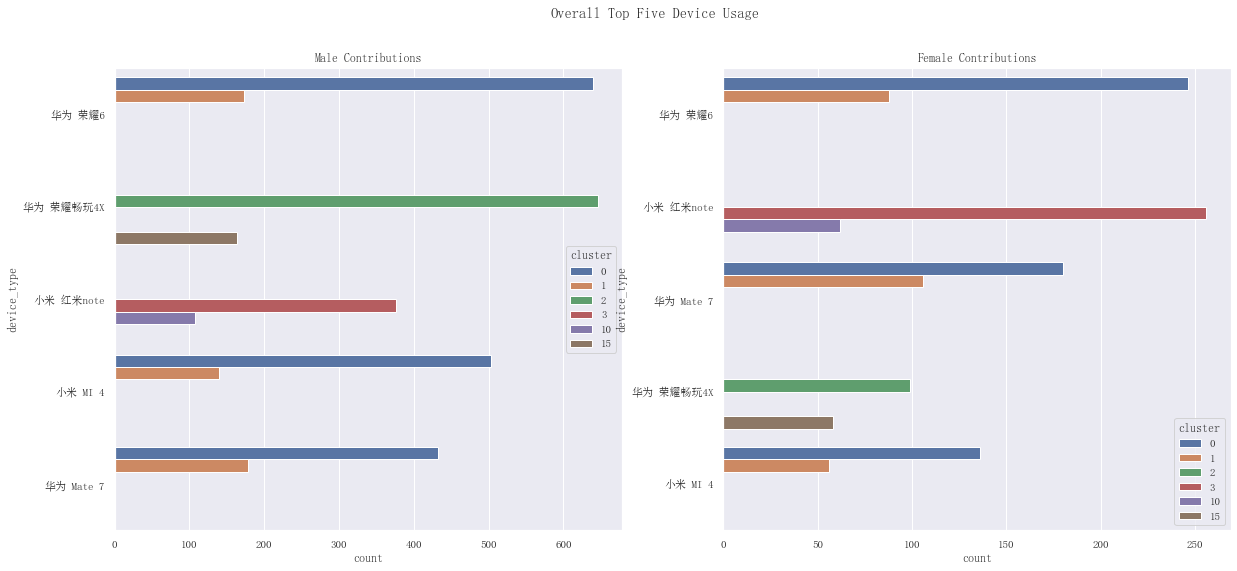

In [30]:

top_five = cluster_model.device_type.value_counts().nlargest(5).keys()
men = cluster_model[cluster_model.gender == 'M']
women = cluster_model[cluster_model.gender == 'F']


men = men[men.device_type.isin(top_five)]
women = women[women.device_type.isin(top_five)]

#Split the count plot.
fig,ax =  plt.subplots(1,2, figsize=(20,8.5))
plt.suptitle('Overall Top Five Device Usage')
sns.countplot(y='device_type', 
            data= men, 
            hue='cluster', 
            ax=ax[0]).set_title('Male Contributions')

sns.countplot(y='device_type', 
            data=women, 
            hue='cluster', 
            ax=ax[1]).set_title("Female Contributions")
plt.show()

In [25]:
top_five_clusters = cluster_model[cluster_model.device_type.isin(top_five)]

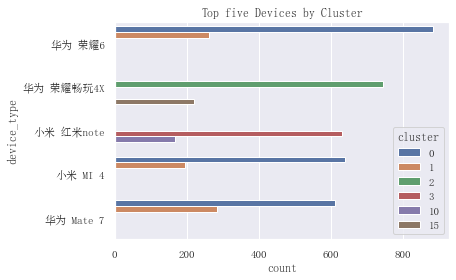

In [29]:
sns.countplot(y='device_type', 
            data= top_five_clusters, 
            hue='cluster').set_title('Top five Devices by Cluster')
plt.show()

In [153]:
#I'm not done visualizing these cluster models; but I may run into some issues later. Exporting the data to csv for future use; if needed.
cluster_model.to_csv('./data/clustered.csv', index=False)

In [174]:
cluster_model.groupby(by='cluster').coordinates.nunique().sort_values(ascending=False)

cluster
0     6218
3      292
2      273
7      117
5      112
8       93
4       82
13      80
17      71
14      56
19      51
9       50
18      30
12      26
16      16
10       1
6        1
11       1
15       1
1        1
Name: coordinates, dtype: int64

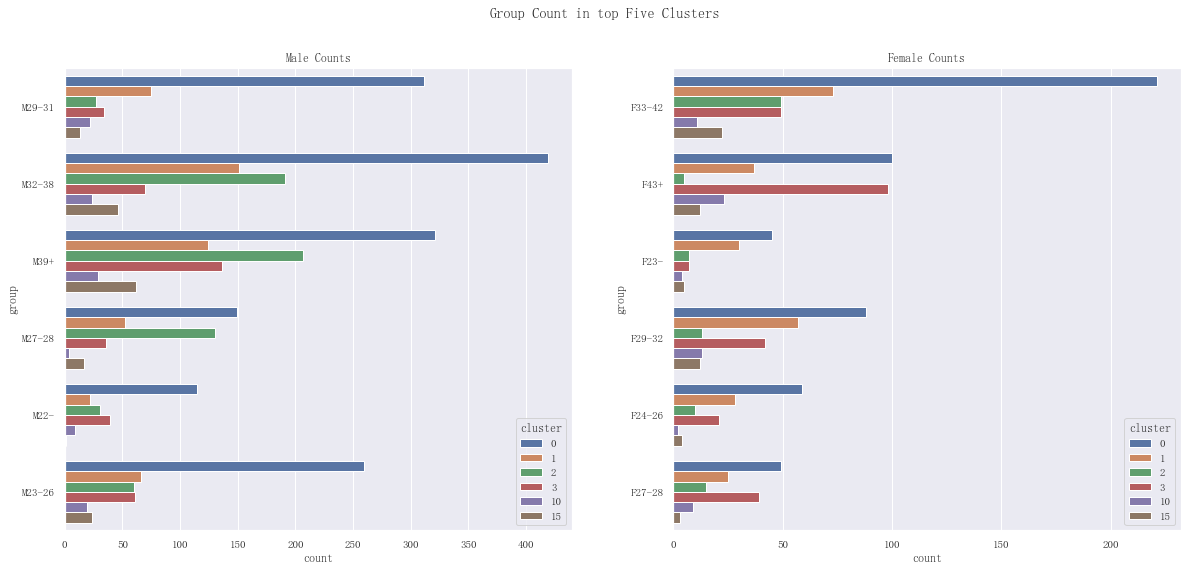

In [184]:
#Split the count plot.
fig,ax =  plt.subplots(1,2, figsize=(20,8.5))
plt.suptitle('Group Count in top Five Clusters')
sns.countplot(y='group', 
            data= men, 
            hue='cluster', 
            ax=ax[0]).set_title('Male Counts')

sns.countplot(y='group', 
            data=women, 
            hue='cluster', 
            ax=ax[1]).set_title("Female Counts")
plt.show()

In [216]:
cluster_model.drop(columns=['longitude', 'latitude']).groupby(by='cluster').nunique().sort_values(by='coordinates', ascending=False)

,coordinates,is_active,category,hour,weekday,week,device_type,gender,group
cluster,,,,,,,,,
0,6218,2,282,24,7,2,431,2,12
3,292,2,115,24,7,2,1,2,12
2,273,2,121,24,7,2,1,2,12
7,117,2,74,23,7,2,1,2,11
5,112,2,64,24,7,2,1,2,9
8,93,2,66,24,7,2,1,2,11
4,82,2,81,24,7,2,1,2,11
13,80,2,65,24,7,2,1,2,11
17,71,2,51,23,7,2,1,2,12


In [211]:
cluster_model[(cluster_model.cluster==1)]

,coordinates,is_active,category,hour,weekday,week,device_type,cluster,latitude,longitude,gender,group
6888916,"(0.0, 0.0)",0.0,Industry tag,17,0,18,OPPO R8205,1,0.0,0.0,M,M32-38
3660344,"(0.0, 0.0)",1.0,Property Industry 2.0,5,5,18,华为 G7 Plus,1,0.0,0.0,M,M32-38
3340681,"(0.0, 0.0)",1.0,Relatives 1,9,4,18,OPPO R1C,1,0.0,0.0,F,F27-28
1980946,"(0.0, 0.0)",1.0,Industry tag,13,1,18,vivo Y27,1,0.0,0.0,F,F33-42
4549595,"(0.0, 0.0)",1.0,video,21,6,17,华为 荣耀6,1,0.0,0.0,M,M27-28
...,...,...,...,...,...,...,...,...,...,...,...,...
4682867,"(0.0, 0.0)",0.0,Property Industry 1.0,12,6,17,vivo X5SL,1,0.0,0.0,M,M22-
2118681,"(0.0, 0.0)",1.0,Industry tag,13,2,18,三星 Galaxy Mega 2,1,0.0,0.0,M,M29-31
7680022,"(0.0, 0.0)",0.0,Internet banking,10,2,18,酷派 Y70-C,1,0.0,0.0,M,M32-38
7405325,"(0.0, 0.0)",0.0,Property Industry 2.0,8,5,18,索尼 Xperia Z2,1,0.0,0.0,F,F27-28
